In [11]:
# Cell 1: imports (NO pip install)
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import itertools

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [12]:
# Cell 2: Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [13]:
# Cell 3: Set dataset path (change only if your folder name differs)
DATA_DIR = '/content/drive/MyDrive/waste_project/images'  # <- this must match your Drive path exactly

# Quick check: list folders and counts
import os

print("DATA_DIR =", DATA_DIR)
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError("Path not found. Check DATA_DIR and your Drive folder names.")

categories = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR,d))])
print("\nCategories found:", categories)
for c in categories:
    p = os.path.join(DATA_DIR, c)
    n = sum(len(files) for _,_,files in os.walk(p))
    print(f"  {c} -> {n} files")


DATA_DIR = /content/drive/MyDrive/waste_project/images

Categories found: ['glass', 'metal', 'organic', 'paper', 'plastic']
  glass -> 100 files
  metal -> 100 files
  organic -> 100 files
  paper -> 100 files
  plastic -> 100 files


In [14]:
# Cell 4: Create generators with a simple train/validation split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224,224)
BATCH_SIZE = 16   # reduce to 8 if you run out of memory
SEED = 42

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)

NUM_CLASSES = train_generator.num_classes
print("\nNum classes:", NUM_CLASSES)
print("Class indices:", train_generator.class_indices)


Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.

Num classes: 5
Class indices: {'glass': 0, 'metal': 1, 'organic': 2, 'paper': 3, 'plastic': 4}


In [15]:
# Cell 5: Build model using MobileNetV2 (transfer learning)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

IMG_SIZE = (224,224)  # already used above

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False   # freeze base for quick training

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

print("Model compiled. Summary:")
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model compiled. Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
# Cell 6: Train the model (small number of epochs for speed)
EPOCHS = 5  # You can reduce to 3 if time is short

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 294s 11s/step - accuracy: 0.2194 - loss: 1.9554 - val_accuracy: 0.3800 - val_loss: 1.5466
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - accuracy: 0.2805 - loss: 1.7694 - val_accuracy: 0.4200 - val_loss: 1.4071
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step - accuracy: 0.3289 - loss: 1.5841 - val_accuracy: 0.4700 - val_loss: 1.3460
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - accuracy: 0.4045 - loss: 1.5502 - val_accuracy: 0.5100 - val_loss: 1.2728
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step - accuracy: 0.3960 - loss: 1.4690 - val_accuracy: 0.4900 - val_loss: 1.2347


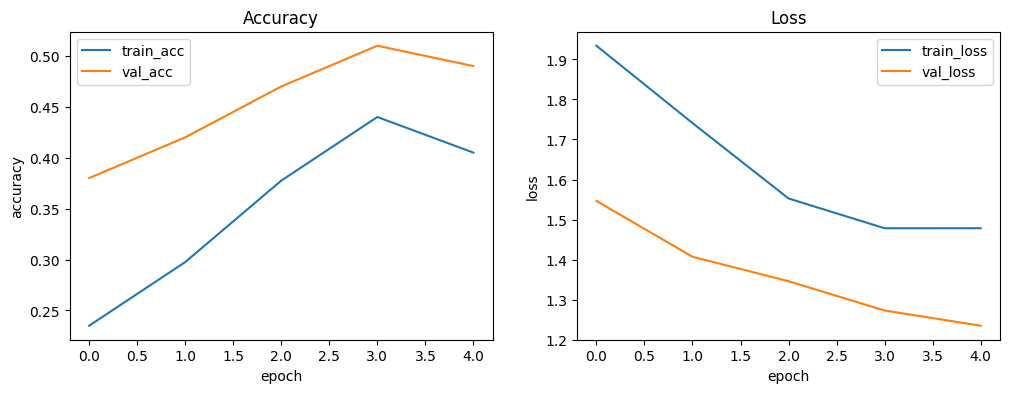

In [18]:
# Cell 7: Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


In [19]:
# Cell 8: Save the trained model to your Drive
MODEL_PATH = '/content/drive/MyDrive/waste_project/waste_classifier.h5'
model.save(MODEL_PATH)
print("Saved model to:", MODEL_PATH)


Saved model to: /content/drive/MyDrive/waste_project/waste_classifier.h5


In [20]:
# Cell 9: Evaluate on validation set (classification report + confusion matrix)
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

val_generator.reset()
preds = model.predict(val_generator, verbose=1)

y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

class_labels = list(train_generator.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=3))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 813ms/step

Classification Report:

              precision    recall  f1-score   support

       glass      0.333     0.250     0.286        20
       metal      0.200     0.200     0.200        20
     organic      0.077     0.100     0.087        20
       paper      0.118     0.100     0.108        20
     plastic      0.136     0.150     0.143        20

    accuracy                          0.160       100
   macro avg      0.173     0.160     0.165       100
weighted avg      0.173     0.160     0.165       100


Confusion Matrix:
 [[ 5  4  3  3  5]
 [ 3  4  6  2  5]
 [ 1  5  2  4  8]
 [ 2  5 10  2  1]
 [ 4  2  5  6  3]]


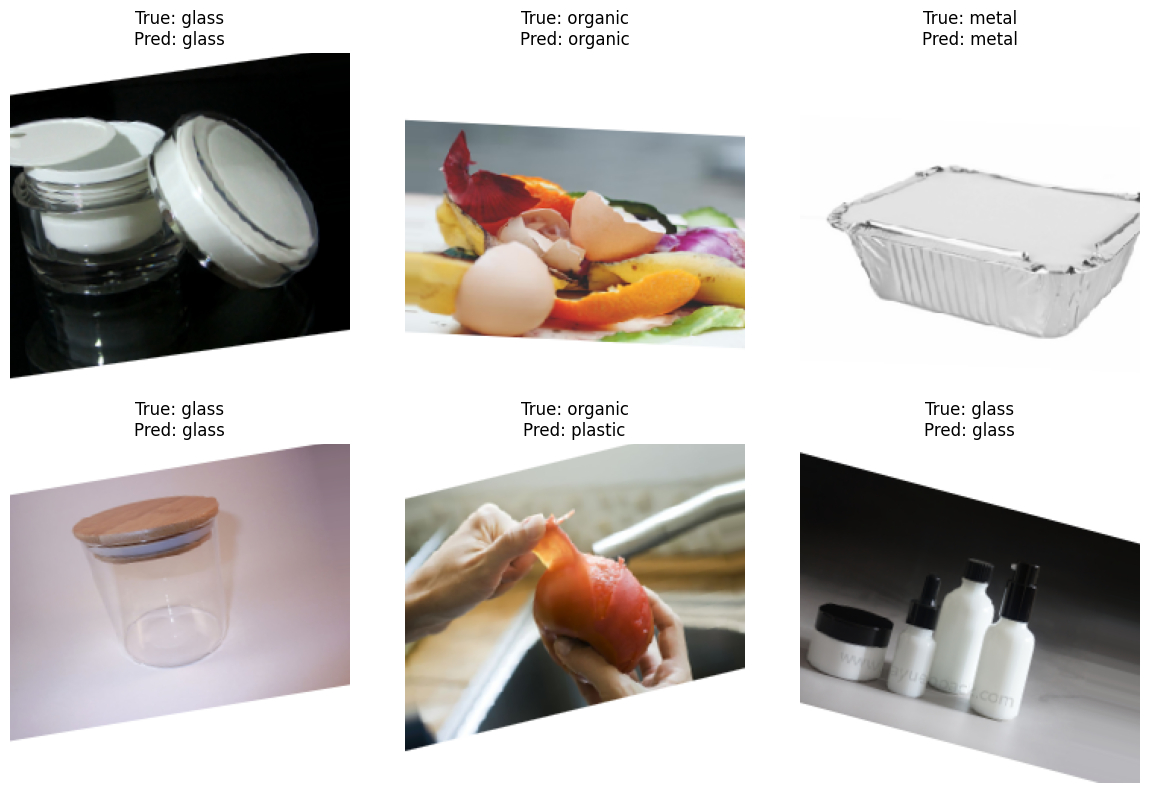

In [23]:
# Fixed Cell 10: Show a few validation images + predicted labels
import matplotlib.pyplot as plt
import numpy as np

val_generator.reset()        # start from beginning
n = 6                       # number of sample images to show
plt.figure(figsize=(12,8))

for i in range(n):
    # use Python's next() to get a batch from the generator
    img_batch, label_batch = next(val_generator)
    img = img_batch[0]                 # first image of the batch
    true_index = np.argmax(label_batch[0])

    # predict on single image (model expects a batch)
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_index = np.argmax(pred[0])

    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f"True: {class_labels[true_index]}\nPred: {class_labels[pred_index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
